In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter
import nltk
# You might need to download these if you haven't already
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# --- Configuration for plots ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

def get_text_lengths(text_series):
    """Calculates character and word lengths for a series of texts."""
    char_lengths = text_series.astype(str).apply(len)
    word_lengths = text_series.astype(str).apply(lambda x: len(x.split()))
    return char_lengths, word_lengths

def plot_text_length_distribution(lengths, title_prefix=""):
    """Plots histogram and boxplot for text lengths."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(lengths, kde=True, bins=50)
    plt.title(f'{title_prefix} Length Distribution (Histogram)')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=lengths)
    plt.title(f'{title_prefix} Length Distribution (Boxplot)')
    plt.xlabel('Length')

    plt.tight_layout()
    plt.show()

    print(f"\nDescriptive Statistics for {title_prefix} Lengths:")
    print(lengths.describe())

def plot_sentiment_distribution(sentiment_series, title=""):
    """Plots the distribution of sentiment labels."""
    plt.figure(figsize=(8, 5))
    sentiment_counts = sentiment_series.value_counts(normalize=True) * 100
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
    plt.title(f'Sentiment Distribution for {title}')
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.show()

    print(f"\nSentiment Value Counts for {title}:")
    print(sentiment_series.value_counts())
    print(f"\nSentiment Proportions for {title}:")
    print(sentiment_series.value_counts(normalize=True))

def plot_topic_distribution(topic_series, title=""):
    """Plots the distribution of topic labels."""
    plt.figure(figsize=(8, 5))
    topic_counts = topic_series.value_counts(normalize=True) * 100
    sns.barplot(x=topic_counts.index, y=topic_counts.values)
    plt.title(f'Topic Distribution for {title}')
    plt.xlabel('Topic')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.show()

    print(f"\nTopic Value Counts for {title}:")
    print(topic_series.value_counts())

def get_most_common_words(text_series, n=20, lang_stopwords='english'):
    """Gets the most common words from a series of texts."""
    # Basic preprocessing: lowercase, tokenize, remove stopwords and punctuation
    all_words = []
    # stopwords_list = nltk.corpus.stopwords.words(lang_stopwords) if lang_stopwords else [] # Be careful with stopwords for sentiment

    for text in text_series.astype(str):
        words = nltk.word_tokenize(text.lower())
        # words = [word for word in words if word.isalpha() and word not in stopwords_list] # Consider if stopwords removal is good
        words = [word for word in words if word.isalpha()] # Keep it simple: only alphabetic
        all_words.extend(words)

    word_counts = Counter(all_words)
    most_common = word_counts.most_common(n)

    print(f"\nTop {n} most common words:")
    for word, count in most_common:
        print(f"{word}: {count}")
    return most_common



[nltk_data] Downloading package punkt to /home/joozy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/joozy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/joozy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EDA

## EDA for FinGPT English Dataset (FinGPT/fingpt-sentiment-train)

In [15]:
# --- 1. EDA for FinGPT English Dataset ---
print("--- EDA for FinGPT English Dataset (FinGPT/fingpt-sentiment-train) ---")

# 1.1 Load Dataset
fingpt_dataset = load_dataset("FinGPT/fingpt-sentiment-train")
fingpt_dataset

--- EDA for FinGPT English Dataset (FinGPT/fingpt-sentiment-train) ---


DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 76772
    })
})

In [16]:
fingpt_df = fingpt_dataset['train'].to_pandas()


# 1.2 Initial Inspection
print("\n--- Initial Inspection ---")
print(f"Shape of the dataset: {fingpt_df.shape}")
print("\nFirst 5 rows:")
print(fingpt_df.head())
print("\nDataset Info:")
fingpt_df.info()
print("\nMissing values:")
print(fingpt_df.isnull().sum())

# Check for duplicates
print(f"\nNumber of duplicate rows: {fingpt_df.duplicated().sum()}")
print(f"Number of duplicate sentences: {fingpt_df['input'].duplicated().sum()}")


--- Initial Inspection ---
Shape of the dataset: (76772, 3)

First 5 rows:
                                               input               output  \
0  Teollisuuden Voima Oyj , the Finnish utility k...              neutral   
1  Sanofi poaches AstraZeneca scientist as new re...              neutral   
2  Starbucks says the workers violated safety pol...  moderately negative   
3                      $brcm raises revenue forecast             positive   
4  Google parent Alphabet Inc. reported revenue a...  moderately negative   

                                         instruction  
0  What is the sentiment of this news? Please cho...  
1  What is the sentiment of this news? Please cho...  
2  What is the sentiment of this news? Please cho...  
3  What is the sentiment of this tweet? Please ch...  
4  What is the sentiment of this news? Please cho...  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76772 entries, 0 to 76771
Data columns (total 3 columns):
 #   Col

There are some samples with more than 1 duplicates so we have to remove them and keep the first occurrence.

In [17]:
import pandas as pd

def remove_duplicates_keep_first(df, column_name):
    """
    Removes duplicate rows based on a given column while keeping the first occurrence.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to check for duplicates.

    Returns:
        pd.DataFrame: A new DataFrame with duplicates removed.
    """
    cleaned_df = df.drop_duplicates(subset=column_name, keep='first').reset_index(drop=True)
    return cleaned_df

fingpt_df = remove_duplicates_keep_first(fingpt_df, 'input')
fingpt_df

,input,output,instruction
0,"Teollisuuden Voima Oyj , the Finnish utility k...",neutral,What is the sentiment of this news? Please cho...
1,Sanofi poaches AstraZeneca scientist as new re...,neutral,What is the sentiment of this news? Please cho...
2,Starbucks says the workers violated safety pol...,moderately negative,What is the sentiment of this news? Please cho...
3,$brcm raises revenue forecast,positive,What is the sentiment of this tweet? Please ch...
4,Google parent Alphabet Inc. reported revenue a...,moderately negative,What is the sentiment of this news? Please cho...
...,...,...,...
30230,CNBC's Kristina Partsinevelos joins 'Squawk Bo...,mildly negative,What is the sentiment of this news? Please cho...
30231,Little is known for sure about a secretive App...,mildly negative,What is the sentiment of this news? Please cho...
30232,Netflix Inc. executives on Tuesday detailed th...,mildly negative,What is the sentiment of this news? Please cho...
30233,NEW YORK — A fire broke out late Wednesday at ...,mildly negative,What is the sentiment of this news? Please cho...



--- Sentiment Analysis ---


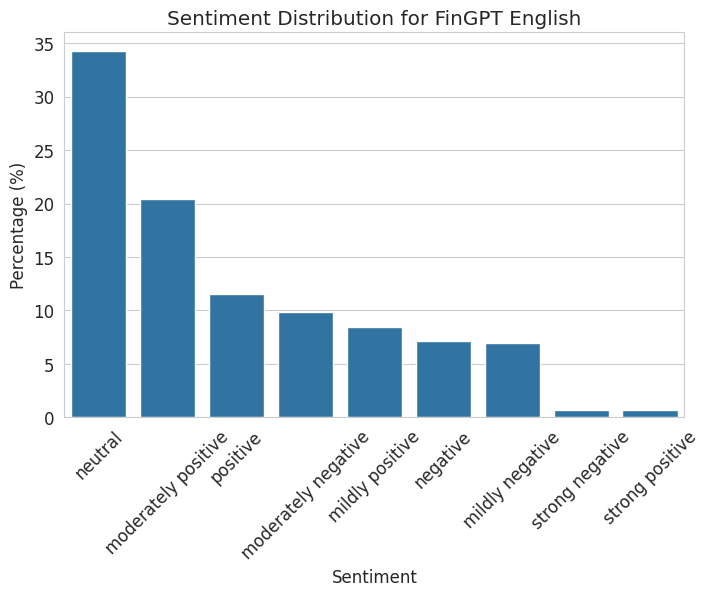


Sentiment Value Counts for FinGPT English:
output
neutral                10362
moderately positive     6163
positive                3484
moderately negative     2972
mildly positive         2548
negative                2169
mildly negative         2108
strong negative          218
strong positive          211
Name: count, dtype: int64

Sentiment Proportions for FinGPT English:
output
neutral                0.342715
moderately positive    0.203837
positive               0.115231
moderately negative    0.098297
mildly positive        0.084273
negative               0.071738
mildly negative        0.069721
strong negative        0.007210
strong positive        0.006979
Name: proportion, dtype: float64

--- Text Analysis (Sentences) ---


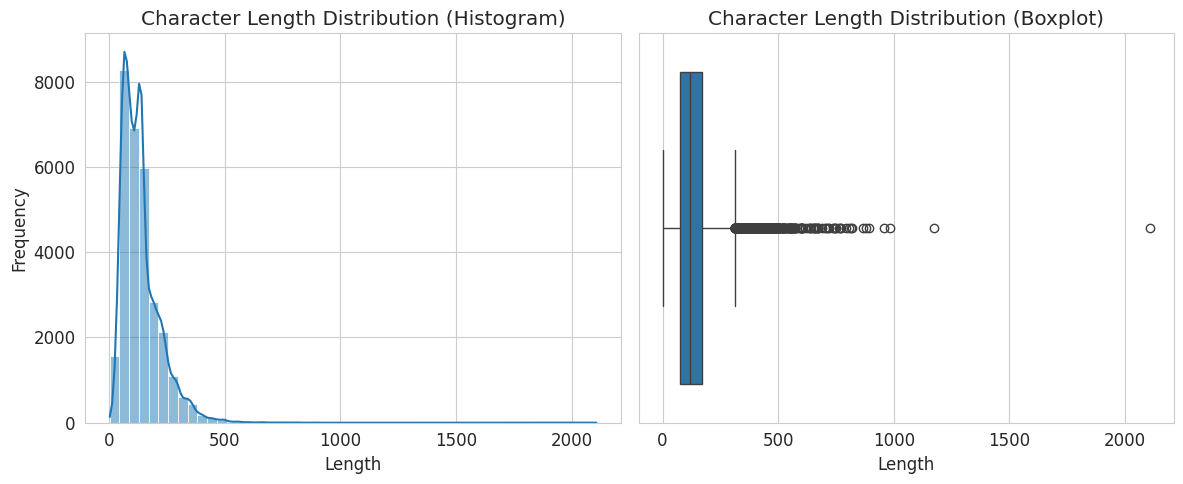


Descriptive Statistics for Character Lengths:
count    30235.000000
mean       135.434397
std         84.076006
min          2.000000
25%         75.000000
50%        119.000000
75%        170.000000
max       2107.000000
Name: char_length, dtype: float64


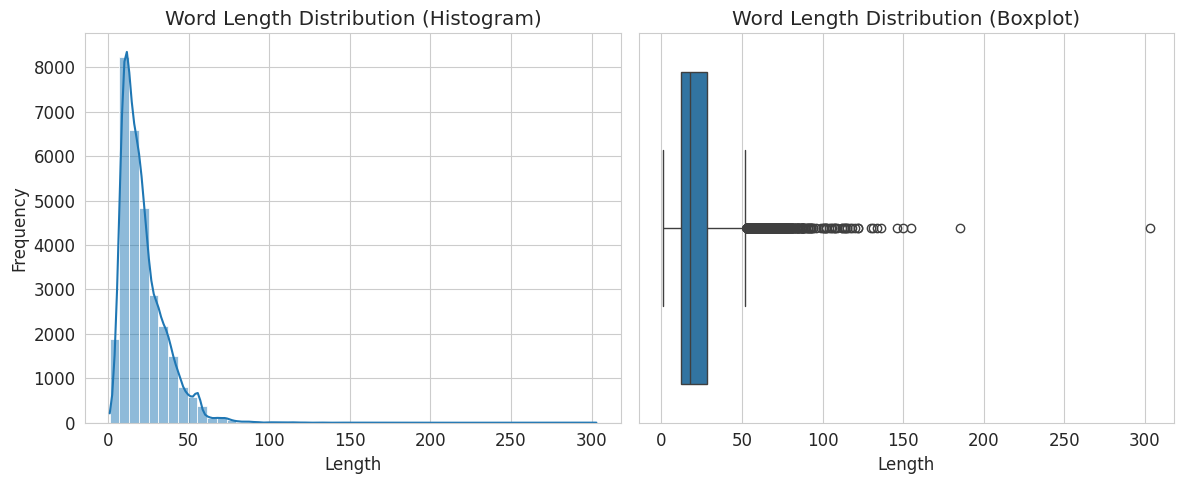


Descriptive Statistics for Word Lengths:
count    30235.000000
mean        21.483281
std         13.564992
min          1.000000
25%         12.000000
50%         18.000000
75%         28.000000
max        303.000000
Name: word_length, dtype: float64

Top 20 most common words:
the: 29420
to: 16779
of: 12758
and: 12309
in: 12224
a: 11922
on: 7557
for: 7257
is: 6401
https: 5334
its: 4708
stock: 3957
with: 3765
as: 3709
that: 3537
are: 3485
it: 3385
at: 3296
has: 3189
from: 3108

--- Potential Impacts on Model Performance (FinGPT English Dataset) ---
- Class Imbalance: Sentiments are not perfectly balanced ({'neutral': 0.34271539606416407, 'moderately positive': 0.20383661319662644, 'positive': 0.11523069290557302, 'moderately negative': 0.09829667603770464, 'mildly positive': 0.08427319331900116, 'negative': 0.07173805192657516, 'mildly negative': 0.06972052257317678, 'strong negative': 0.007210186869522077, 'strong positive': 0.006978667107656689}). This might lead to bias towards majo

In [18]:
# 1.3 Descriptive Statistics
# Sentiment Analysis
print("\n--- Sentiment Analysis ---")
plot_sentiment_distribution(fingpt_df['output'], title="FinGPT English")

# Text Analysis
print("\n--- Text Analysis (Sentences) ---")
if 'input' in fingpt_df.columns:
    fingpt_df['char_length'], fingpt_df['word_length'] = get_text_lengths(fingpt_df['input'])

    plot_text_length_distribution(fingpt_df['char_length'], title_prefix="Character")
    plot_text_length_distribution(fingpt_df['word_length'], title_prefix="Word")

    # Most common words (optional, can be slow on large datasets)
    get_most_common_words(fingpt_df['input'], lang_stopwords='english')

    # 1.4 Highlight findings that could potentially impact model performance (example)
    print("\n--- Potential Impacts on Model Performance (FinGPT English Dataset) ---")
    if 'output' in fingpt_df.columns:
        sentiment_counts = fingpt_df['output'].value_counts(normalize=True)
        if any(count < 0.1 for count in sentiment_counts): # Example threshold for imbalance
            print(f"- Class Imbalance: Sentiments are not perfectly balanced ({sentiment_counts.to_dict()}). This might lead to bias towards majority classes.")
        else:
            print("- Class Balance: Sentiment classes appear reasonably balanced.")

    if 'word_length' in fingpt_df.columns:
        if fingpt_df['word_length'].max() > 500: # Example threshold for long texts
            print(f"- Long Texts: Some texts are quite long (max: {fingpt_df['word_length'].max()} words). Truncation might be needed, potentially losing context.")
        if fingpt_df['word_length'].min() < 5: # Example threshold for short texts
            print(f"- Short Texts: Some texts are very short (min: {fingpt_df['word_length'].min()} words), which might lack context for the model.")

    if fingpt_df['input'].duplicated().sum() > 0:
        print(f"- Duplicate Sentences: Found {fingpt_df['input'].duplicated().sum()} duplicate sentences. Ensure these are handled appropriately in train/eval splits.")
else:
    print("Skipping FinGPT EDA due to loading error.")

In [19]:
# Filter examples with word length 1 and 303
print("\n--- Specific Word Length Examples ---")
word_length_1 = fingpt_df[fingpt_df['word_length'] == 1]
word_length_303 = fingpt_df[fingpt_df['word_length'] == 303]

# Display counts and examples
print(f"Examples with word length = 1: {len(word_length_1)}")
if not word_length_1.empty:
    print(word_length_1[['input', 'word_length']])

print(f"\nExamples with word length = 303: {len(word_length_303)}")
if not word_length_303.empty:
    print(word_length_303[['input', 'word_length']])


--- Specific Word Length Examples ---
Examples with word length = 1: 28
                                        input  word_length
49                                      $TSLA            1
750                   https://t.co/9eZPvQhfMq            1
1230                                      LHC            1
2428                                  @TicToc            1
3503                                     HSAC            1
3680                         SASA聚酯选用英威达PTA技术            1
5709                                       :)            1
7222                 Wipro赢得Marelli的多年战略性IT协议            1
9881                                     LJPC            1
10317                                   LTRPB            1
12002                                   SBFGP            1
12252                                    ACHV            1
15669                                     WBK            1
16546                 https://t.co/oJxNPEUpWq            1
17036  GSMA：気候の非常事態への対策として大幅な炭素削減を可能にするモバイ

## EDA for Vietnamese Student Feedback Dataset (uitnlp/vietnamese_students_feedback)

This dataset has 3 splits: train, validation and test. whereas the fingpt dataset earlier only had a default train split.
We could also read the dataset card on Hugging Face to see the different splits and their sizes and the classes in the dataset.

### EDA on the trian split

In [20]:
print("\n\n--- EDA for Vietnamese Student Feedback Dataset (uitnlp/vietnamese_students_feedback) ---")

viet_dataset_dict = load_dataset("uitnlp/vietnamese_students_feedback")
viet_dataset_dict



--- EDA for Vietnamese Student Feedback Dataset (uitnlp/vietnamese_students_feedback) ---


DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

In [21]:
viet_df = viet_dataset_dict['train'].to_pandas()
viet_df

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
11421,chỉ vì môn game mà em học hai lần mà không qua...,0,1
11422,em cảm ơn cô nhiều .,2,0
11423,giao bài tập quá nhiều .,0,0
11424,"giáo viên dạy dễ hiểu , nhiệt tình .",2,0


In [22]:
# 2.2 Initial Inspection
print("\n--- Initial Inspection ---")
print(f"Shape of the dataset: {viet_df.shape}")
print("\nFirst 5 rows:")
print(viet_df.head()) # Columns are 'sentence', 'label'
print("\nDataset Info:")
viet_df.info()
print("\nMissing values:")
print(viet_df.isnull().sum())

# Check unique values in sentiment and topic columns
if 'sentiment' in viet_df.columns:
    print("\nUnique values in 'sentiment' column:")
    print(viet_df['sentiment'].unique())

if 'topic' in viet_df.columns:
    print("\nUnique values in 'topic' column:")
    print(viet_df['topic'].unique())

# Frequency counts
if 'sentiment' in viet_df.columns:
    print("\nValue counts for 'sentiment' column:")
    print(viet_df['sentiment'].value_counts())

if 'topic' in viet_df.columns:
    print("\nValue counts for 'topic' column:")
    print(viet_df['topic'].value_counts())

# Check for duplicates
print(f"\nNumber of duplicate rows: {viet_df.duplicated().sum()}")
if 'sentence' in viet_df.columns:
    print(f"Number of duplicate sentences: {viet_df['sentence'].duplicated().sum()}")


--- Initial Inspection ---
Shape of the dataset: (11426, 3)

First 5 rows:
                                            sentence  sentiment  topic
0                          slide giáo trình đầy đủ .          2      1
1     nhiệt tình giảng dạy , gần gũi với sinh viên .          2      0
2               đi học đầy đủ full điểm chuyên cần .          0      1
3  chưa áp dụng công nghệ thông tin và các thiết ...          0      0
4  thầy giảng bài hay , có nhiều bài tập ví dụ ng...          2      0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11426 non-null  object
 1   sentiment  11426 non-null  int64 
 2   topic      11426 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 267.9+ KB

Missing values:
sentence     0
sentiment    0
topic        0
dtype: int64

Unique values in 'sentiment' column:
[2 0 1]

Unique

Its interesting to see that there is a same sentence with different sentiment and topic

In [23]:
# Find duplicate sentences
duplicate_sentences = viet_df[viet_df['sentence'].duplicated(keep=False)]

# Display the duplicates
print("\n--- Duplicate Sentences and Corresponding Rows ---")
print(duplicate_sentences.sort_values(by='sentence'))


--- Duplicate Sentences and Corresponding Rows ---
                                                sentence  sentiment  topic
11293  thầy dạy hay , tuy nhiên còn nhiều chỗ chưa th...          2      0
11417  thầy dạy hay , tuy nhiên còn nhiều chỗ chưa th...          0      0


In [24]:
viet_df.shape

(11426, 3)

In [26]:
# Remove both duplicates from the dataset
viet_df = viet_df[viet_df.duplicated(subset=['sentence'], keep=False) == False]
viet_df.shape


(11424, 3)

Realising that it is a duplicate sentence where for the same topic, the sentiment is different, these 2 samplesshould be removed. Perhaps if the sentence was duplicated and had different sentiment score for a different topic, these 2 sample should be kept.


--- Sentiment Analysis ---


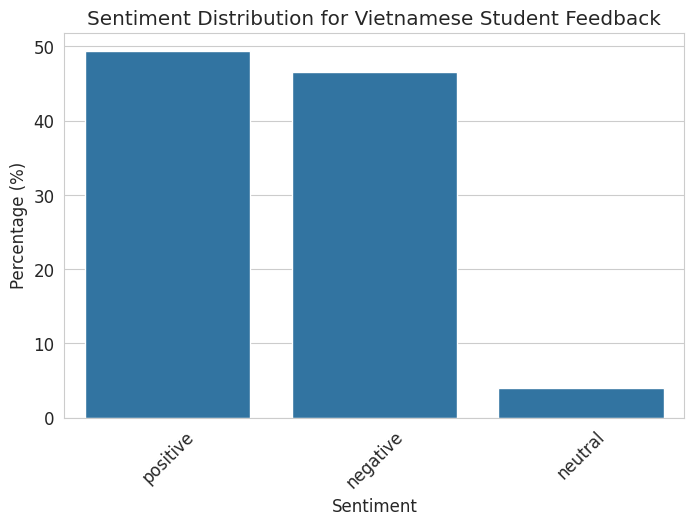


Sentiment Value Counts for Vietnamese Student Feedback:
sentiment_label_str
positive    5643
negative    5325
neutral      458
Name: count, dtype: int64

Sentiment Proportions for Vietnamese Student Feedback:
sentiment_label_str
positive    0.493874
negative    0.466042
neutral     0.040084
Name: proportion, dtype: float64


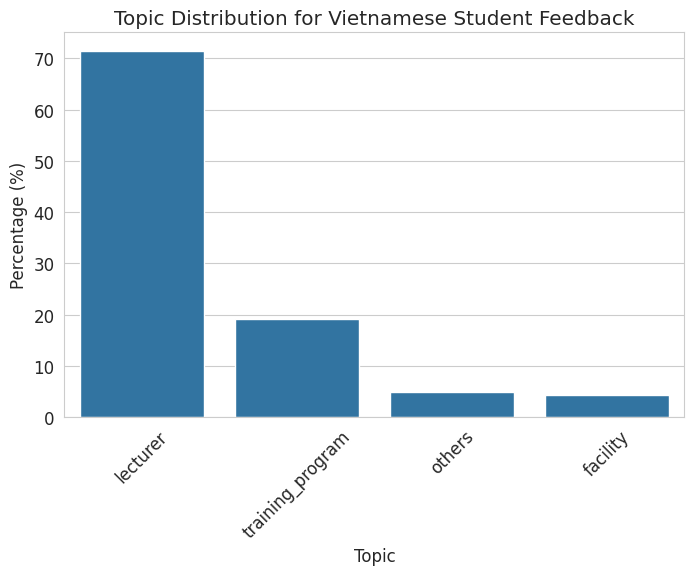


Topic Value Counts for Vietnamese Student Feedback:
topic_label_str
lecturer            8166
training_program    2201
others               562
facility             497
Name: count, dtype: int64

--- Text Analysis (Sentences) ---


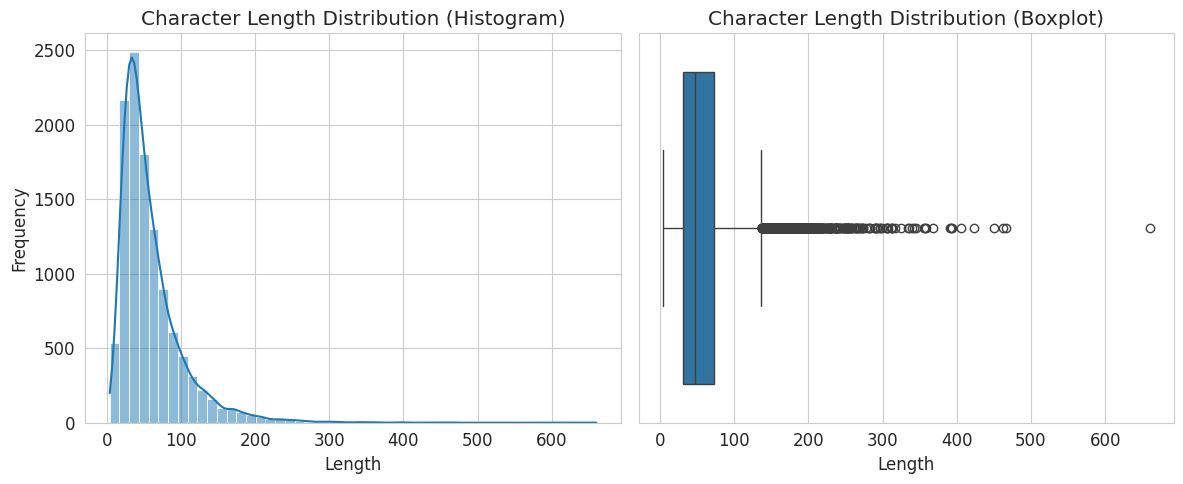


Descriptive Statistics for Character Lengths:
count    11426.000000
mean        59.084894
std         43.085202
min          4.000000
25%         31.000000
50%         47.000000
75%         73.000000
max        660.000000
Name: char_length, dtype: float64


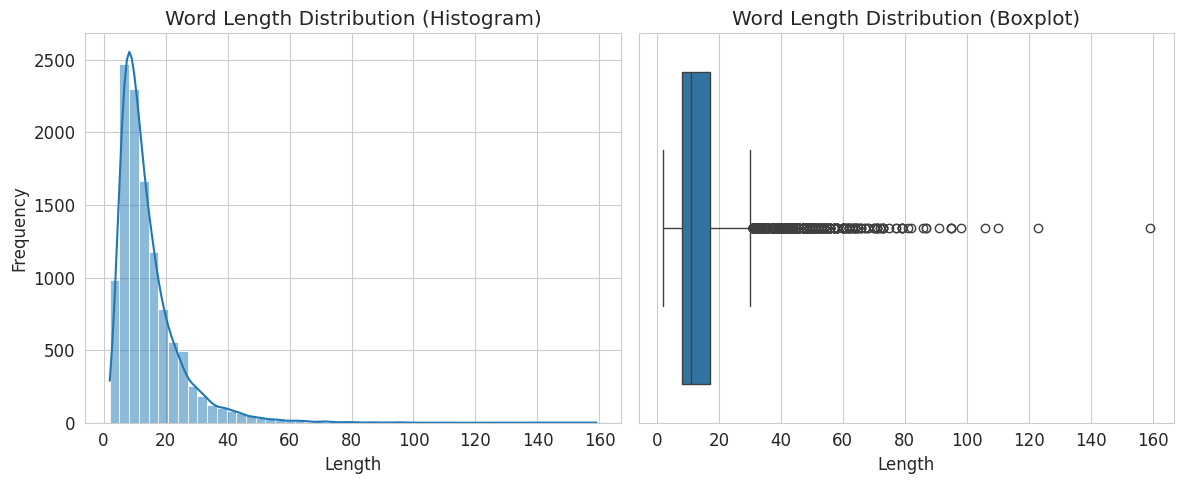


Descriptive Statistics for Word Lengths:
count    11426.000000
mean        14.308769
std         10.089727
min          2.000000
25%          8.000000
50%         11.000000
75%         17.000000
max        159.000000
Name: word_length, dtype: float64


In [13]:
# 2.3 Descriptive Statistics
# Sentiment Analysis - 'label' column needs mapping for clarity
print("\n--- Sentiment Analysis ---")
if 'sentiment' in viet_df.columns:
    # From Hugging Face dataset card for uitnlp/vietnamese_students_feedback:
    # 0: Tiêu cực (Negative)
    # 1: Trung tính (Neutral)
    # 2: Tích cực (Positive)
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    viet_df['sentiment_label_str'] = viet_df['sentiment'].map(label_map)
    plot_sentiment_distribution(viet_df['sentiment_label_str'], title="Vietnamese Student Feedback")
else:
    print("Column 'label' not found in Vietnamese dataset.")

if 'topic' in viet_df.columns:
    label_map = {0: 'lecturer', 1: 'training_program', 2: 'facility', 3: 'others'}
    viet_df['topic_label_str'] = viet_df['topic'].map(label_map)
    plot_topic_distribution(viet_df['topic_label_str'], title="Vietnamese Student Feedback")

# Text Analysis
print("\n--- Text Analysis (Sentences) ---")
if 'sentence' in viet_df.columns:
    viet_df['char_length'], viet_df['word_length'] = get_text_lengths(viet_df['sentence'])

    plot_text_length_distribution(viet_df['char_length'], title_prefix="Character")
    plot_text_length_distribution(viet_df['word_length'], title_prefix="Word")

    # Most common words (stopwords for Vietnamese would require a specific list or library)
    # get_most_common_words(viet_df['sentence'], lang_stopwords=None) # No standard NLTK Vietnamese stopwords
else:
    print("Column 'sentence' not found in Vietnamese dataset.")


### EDA on the validation split

In [28]:
viet_df_val = viet_dataset_dict['validation'].to_pandas()
viet_df_val

,sentence,sentiment,topic
0,giáo trình chưa cụ thể .,0,1
1,giảng buồn ngủ .,0,0
2,"giáo viên vui tính , tận tâm .",2,0
3,"giảng viên nên giao bài tập nhiều hơn , chia n...",0,0
4,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",0,0
...,...,...,...
1578,hướng dẫn lab mơ hồ .,0,0
1579,thầy cho chúng em những bài tập mang tính thực...,2,0
1580,thầy không dạy nhiều chủ yếu cho sinh viên tự ...,0,0
1581,em muốn đổi tên môn học vì tên môn là lập trìn...,0,1


In [29]:
# 2.2 Initial Inspection
print("\n--- Initial Inspection ---")
print(f"Shape of the dataset: {viet_df_val.shape}")
print("\nFirst 5 rows:")
print(viet_df_val.head()) # Columns are 'sentence', 'label'
print("\nDataset Info:")
viet_df_val.info()
print("\nMissing values:")
print(viet_df_val.isnull().sum())

# Check unique values in sentiment and topic columns
if 'sentiment' in viet_df_val.columns:
    print("\nUnique values in 'sentiment' column:")
    print(viet_df_val['sentiment'].unique())

if 'topic' in viet_df_val.columns:
    print("\nUnique values in 'topic' column:")
    print(viet_df_val['topic'].unique())

# Frequency counts
if 'sentiment' in viet_df_val.columns:
    print("\nValue counts for 'sentiment' column:")
    print(viet_df_val['sentiment'].value_counts())

if 'topic' in viet_df_val.columns:
    print("\nValue counts for 'topic' column:")
    print(viet_df_val['topic'].value_counts())

# Check for duplicates
print(f"\nNumber of duplicate rows: {viet_df_val.duplicated().sum()}")
if 'sentence' in viet_df_val.columns:
    print(f"Number of duplicate sentences: {viet_df_val['sentence'].duplicated().sum()}")


--- Initial Inspection ---
Shape of the dataset: (1583, 3)

First 5 rows:
                                            sentence  sentiment  topic
0                           giáo trình chưa cụ thể .          0      1
1                                   giảng buồn ngủ .          0      0
2                     giáo viên vui tính , tận tâm .          2      0
3  giảng viên nên giao bài tập nhiều hơn , chia n...          0      0
4  giảng viên cần giảng bài chi tiết hơn , đi sâu...          0      0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   1583 non-null   object
 1   sentiment  1583 non-null   int64 
 2   topic      1583 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 37.2+ KB

Missing values:
sentence     0
sentiment    0
topic        0
dtype: int64

Unique values in 'sentiment' column:
[0 2 1]

Unique val


--- Sentiment Analysis ---


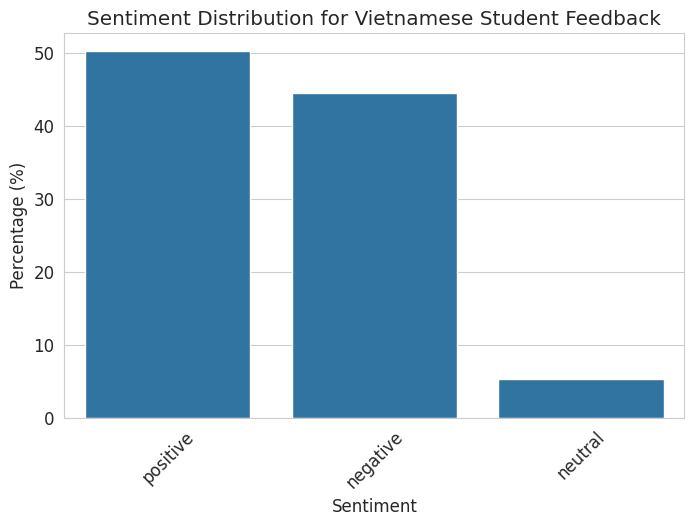


Sentiment Value Counts for Vietnamese Student Feedback:
sentiment_label_str
positive    1590
negative    1409
neutral      167
Name: count, dtype: int64

Sentiment Proportions for Vietnamese Student Feedback:
sentiment_label_str
positive    0.502211
negative    0.445041
neutral     0.052748
Name: proportion, dtype: float64


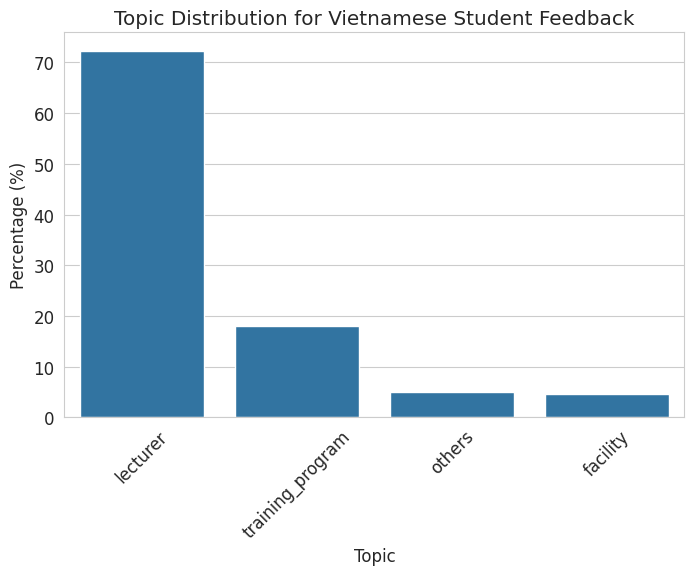


Topic Value Counts for Vietnamese Student Feedback:
topic_label_str
lecturer            2290
training_program     572
others               159
facility             145
Name: count, dtype: int64

--- Text Analysis (Sentences) ---


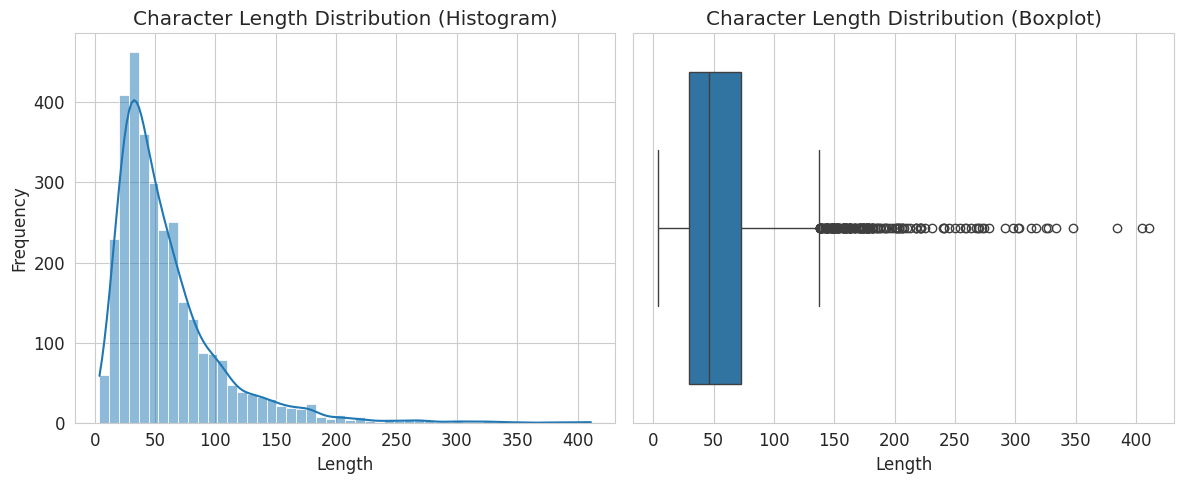


Descriptive Statistics for Character Lengths:
count    3166.000000
mean       58.836387
std        44.128282
min         4.000000
25%        30.000000
50%        46.000000
75%        73.000000
max       411.000000
Name: char_length, dtype: float64


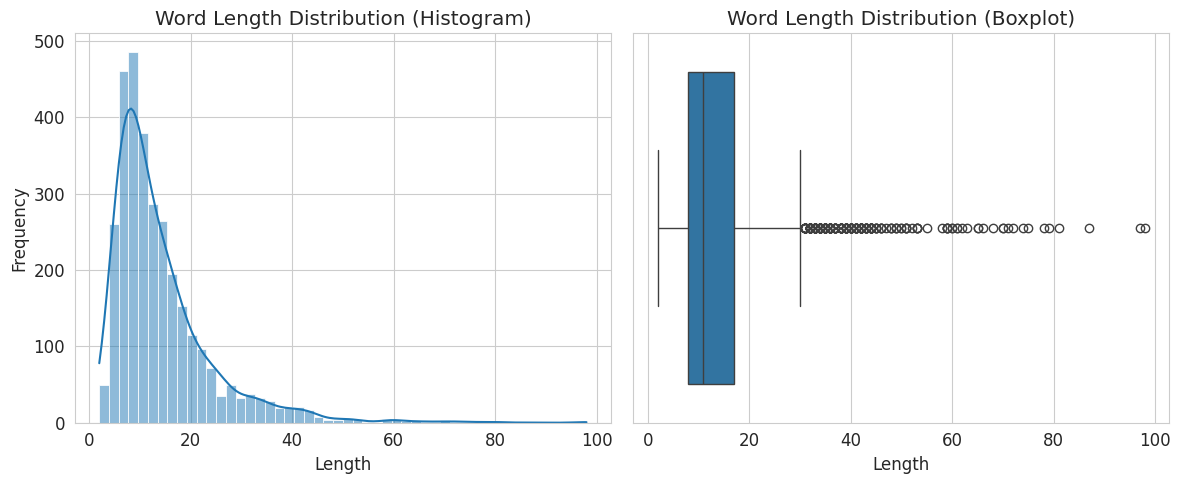


Descriptive Statistics for Word Lengths:
count    3166.000000
mean       14.220783
std        10.242381
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        98.000000
Name: word_length, dtype: float64


In [30]:
# 2.3 Descriptive Statistics
# Sentiment Analysis - 'label' column needs mapping for clarity
print("\n--- Sentiment Analysis ---")
if 'sentiment' in viet_df_val.columns:
    # From Hugging Face dataset card for uitnlp/vietnamese_students_feedback:
    # 0: Tiêu cực (Negative)
    # 1: Trung tính (Neutral)
    # 2: Tích cực (Positive)
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    viet_df_val['sentiment_label_str'] = viet_df_val['sentiment'].map(label_map)
    plot_sentiment_distribution(viet_df_val['sentiment_label_str'], title="Vietnamese Student Feedback")
else:
    print("Column 'label' not found in Vietnamese dataset.")

if 'topic' in viet_df_val.columns:
    label_map = {0: 'lecturer', 1: 'training_program', 2: 'facility', 3: 'others'}
    viet_df_val['topic_label_str'] = viet_df_val['topic'].map(label_map)
    plot_topic_distribution(viet_df_val['topic_label_str'], title="Vietnamese Student Feedback")

# Text Analysis
print("\n--- Text Analysis (Sentences) ---")
if 'sentence' in viet_df_val.columns:
    viet_df_val['char_length'], viet_df_val['word_length'] = get_text_lengths(viet_df_val['sentence'])

    plot_text_length_distribution(viet_df_val['char_length'], title_prefix="Character")
    plot_text_length_distribution(viet_df_val['word_length'], title_prefix="Word")

    # Most common words (stopwords for Vietnamese would require a specific list or library)
    # get_most_common_words(viet_df_val['sentence'], lang_stopwords=None) # No standard NLTK Vietnamese stopwords
else:
    print("Column 'sentence' not found in Vietnamese dataset.")


### EDA on the test split

In [31]:
viet_df_test = viet_dataset_dict['test'].to_pandas()
viet_df_test

,sentence,sentiment,topic
0,nói tiếng anh lưu loát .,2,0
1,giáo viên rất vui tính .,2,0
2,cô max có tâm .,2,0
3,"giảng bài thu hút , dí dỏm .",2,0
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",0,0
...,...,...,...
3161,"các slide khó hiểu , ngôn ngữ trong slide phức...",0,0
3162,giáo viên giảng dạy có tâm huyết .,2,0
3163,chia sẻ cho em nhiều điều hay .,2,0
3164,em tiếp thu chậm .,0,0


In [32]:
# 2.2 Initial Inspection
print("\n--- Initial Inspection ---")
print(f"Shape of the dataset: {viet_df_test.shape}")
print("\nFirst 5 rows:")
print(viet_df_test.head()) # Columns are 'sentence', 'label'
print("\nDataset Info:")
viet_df_test.info()
print("\nMissing values:")
print(viet_df_test.isnull().sum())

# Check unique values in sentiment and topic columns
if 'sentiment' in viet_df_test.columns:
    print("\nUnique values in 'sentiment' column:")
    print(viet_df_test['sentiment'].unique())

if 'topic' in viet_df_test.columns:
    print("\nUnique values in 'topic' column:")
    print(viet_df_test['topic'].unique())

# Frequency counts
if 'sentiment' in viet_df_test.columns:
    print("\nValue counts for 'sentiment' column:")
    print(viet_df_test['sentiment'].value_counts())

if 'topic' in viet_df_test.columns:
    print("\nValue counts for 'topic' column:")
    print(viet_df_test['topic'].value_counts())

# Check for duplicates
print(f"\nNumber of duplicate rows: {viet_df_test.duplicated().sum()}")
if 'sentence' in viet_df_test.columns:
    print(f"Number of duplicate sentences: {viet_df_test['sentence'].duplicated().sum()}")


--- Initial Inspection ---
Shape of the dataset: (3166, 3)

First 5 rows:
                                            sentence  sentiment  topic
0                           nói tiếng anh lưu loát .          2      0
1                           giáo viên rất vui tính .          2      0
2                                    cô max có tâm .          2      0
3                       giảng bài thu hút , dí dỏm .          2      0
4  giáo viên không giảng dạy kiến thức , hướng dẫ...          0      0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   3166 non-null   object
 1   sentiment  3166 non-null   int64 
 2   topic      3166 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 74.3+ KB

Missing values:
sentence     0
sentiment    0
topic        0
dtype: int64

Unique values in 'sentiment' column:
[2 0 1]

Unique val


--- Sentiment Analysis ---


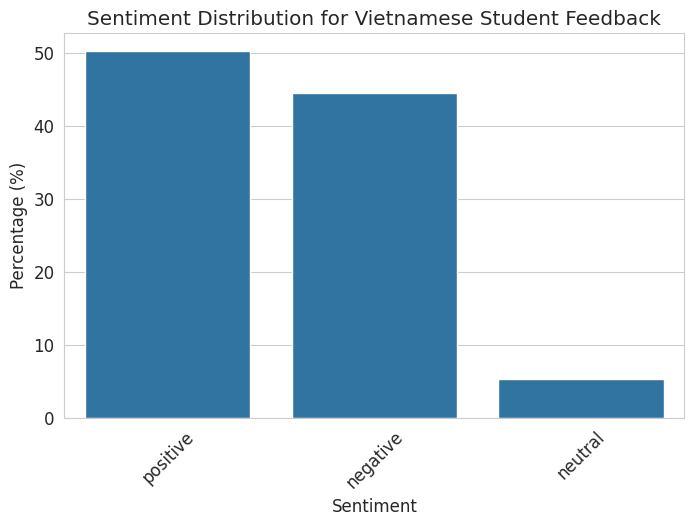


Sentiment Value Counts for Vietnamese Student Feedback:
sentiment_label_str
positive    1590
negative    1409
neutral      167
Name: count, dtype: int64

Sentiment Proportions for Vietnamese Student Feedback:
sentiment_label_str
positive    0.502211
negative    0.445041
neutral     0.052748
Name: proportion, dtype: float64


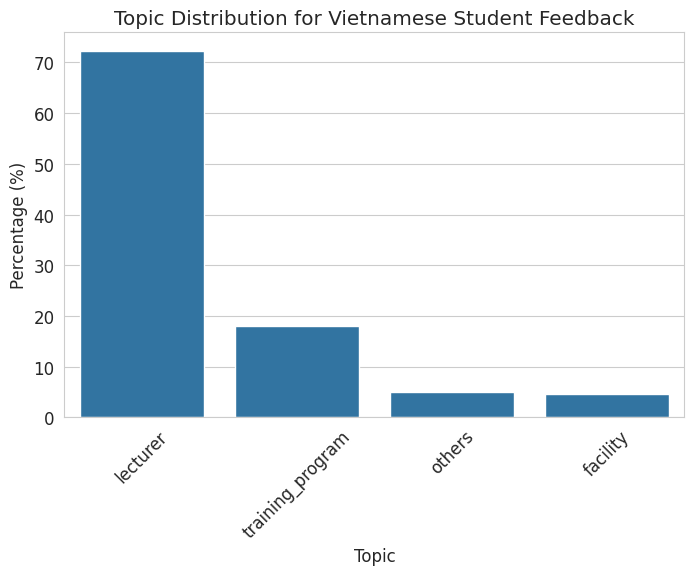


Topic Value Counts for Vietnamese Student Feedback:
topic_label_str
lecturer            2290
training_program     572
others               159
facility             145
Name: count, dtype: int64

--- Text Analysis (Sentences) ---


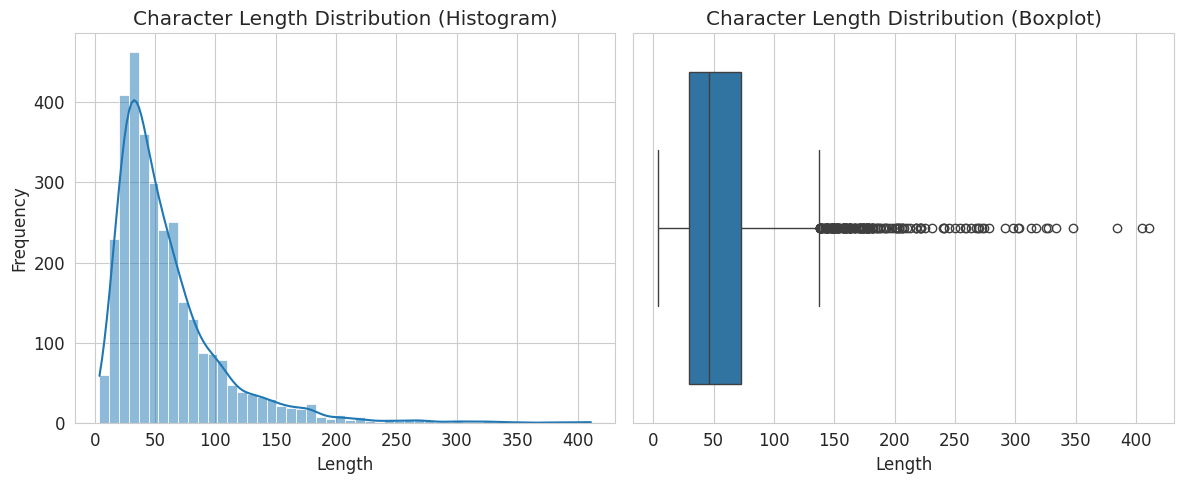


Descriptive Statistics for Character Lengths:
count    3166.000000
mean       58.836387
std        44.128282
min         4.000000
25%        30.000000
50%        46.000000
75%        73.000000
max       411.000000
Name: char_length, dtype: float64


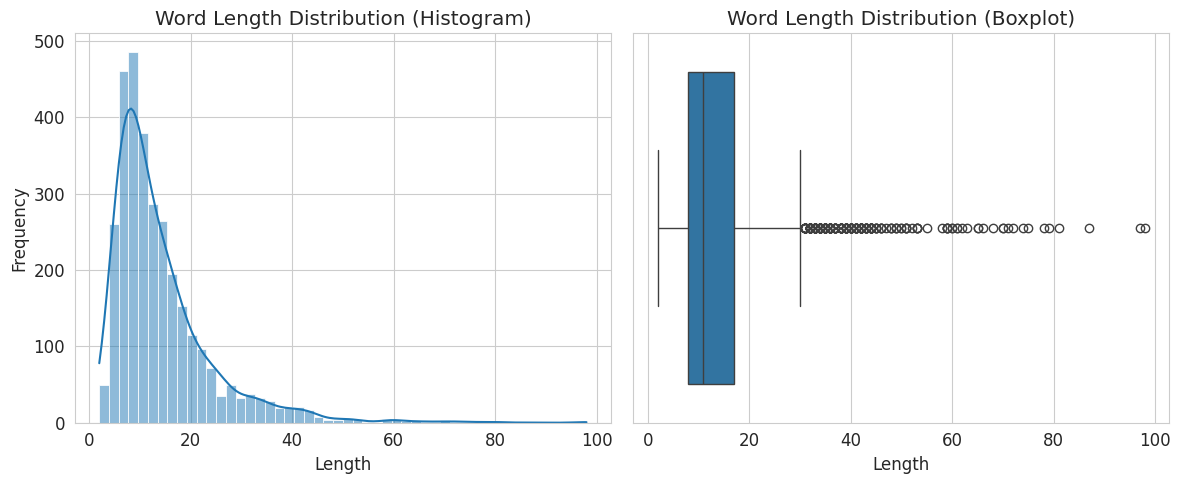


Descriptive Statistics for Word Lengths:
count    3166.000000
mean       14.220783
std        10.242381
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        98.000000
Name: word_length, dtype: float64


In [33]:
# 2.3 Descriptive Statistics
# Sentiment Analysis - 'label' column needs mapping for clarity
print("\n--- Sentiment Analysis ---")
if 'sentiment' in viet_df_test.columns:
    # From Hugging Face dataset card for uitnlp/vietnamese_students_feedback:
    # 0: Tiêu cực (Negative)
    # 1: Trung tính (Neutral)
    # 2: Tích cực (Positive)
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    viet_df_test['sentiment_label_str'] = viet_df_test['sentiment'].map(label_map)
    plot_sentiment_distribution(viet_df_test['sentiment_label_str'], title="Vietnamese Student Feedback")
else:
    print("Column 'label' not found in Vietnamese dataset.")

if 'topic' in viet_df_test.columns:
    label_map = {0: 'lecturer', 1: 'training_program', 2: 'facility', 3: 'others'}
    viet_df_test['topic_label_str'] = viet_df_test['topic'].map(label_map)
    plot_topic_distribution(viet_df_test['topic_label_str'], title="Vietnamese Student Feedback")

# Text Analysis
print("\n--- Text Analysis (Sentences) ---")
if 'sentence' in viet_df_test.columns:
    viet_df_test['char_length'], viet_df_test['word_length'] = get_text_lengths(viet_df_test['sentence'])

    plot_text_length_distribution(viet_df_test['char_length'], title_prefix="Character")
    plot_text_length_distribution(viet_df_test['word_length'], title_prefix="Word")

    # Most common words (stopwords for Vietnamese would require a specific list or library)
    # get_most_common_words(viet_df_test['sentence'], lang_stopwords=None) # No standard NLTK Vietnamese stopwords
else:
    print("Column 'sentence' not found in Vietnamese dataset.")


# EDA Conclusions
- FinGPT English Dataset has only a train split, we had to analyse the train validation and test splits for the Vietnamese dataset.
- The FinGPT English Dataset has 9 classes with granular sentiment classes. Moreover not all instructions instruct an LLM to choose from the same set of 9 classes. Some even instruct an LLM to choose from only 34 classes, positive or negative or neutral.
- The Vietnamese dataset has 3 classes only, positive, negative and neutral.
- Hence to unify the 2 datasets, we will map the FinGPT English Dataset's 9 classes into the Vietnamese dataset's 3 classes to ensure consistency and the instruction used to instruct the LLM to choose will be handled later on during synthetic data generation
- The FinGPT English Dataset had a significant amount of duplicates to which we handle them by keeping the first occurrence.
- The FinGPT English Dataset has some sample sentneces with word length 1 where some are URL links and some are chinese or japanese characters or even ":)". As such when we sample and choose a subset of the dataset, we should be careful to not include meaningless samples. 
- The Vietnamese dataset only had 1 duplicate sentence which we remove both occurrences because the same sentence about the same topic resulted in 2 different sentiments.
- The Vietnamese dataset has an extra topic label class which FinGPT does not. We should be careful to sample evenly across all topic classes.
- Both datasets have class imbalances which since we are taking a smaller sampled subset of the dataset, we should be careful to not introduce bias by overrepresenting a class by sampling evenly across all classes.

## Discussion Question 1
Document down any differences that you have made in the Vietnamese EDA pipeline as compared to the English EDA pipeline and explain why.


1.  **Source Data Structure and Initial Loading:**
    *   **English (FinGPT):**
        *   **Difference:** Loaded from a single `train` split.
        *   **Reason:** The `FinGPT/fingpt-sentiment-train` dataset on Hugging Face is provided as a single split.
    *   **Vietnamese (uitnlp/vietnamese\_students\_feedback):**
        *   **Difference:** Loaded from three separate splits (`train`, `validation`, `test`) which were then concatenated into a single DataFrame.
        *   **Reason:** The `uitnlp/vietnamese_students_feedback` dataset is provided with pre-defined train, validation, and test splits. To maximize the available data for our custom train/evaluation split and to ensure we capture as many samples as possible (especially from the underrepresented 'neutral' class), all splits were combined.

2.  **Initial Column Names and Target Format Alignment:**
    *   **English:**
        *   **Difference:** Original columns (`input`, `output`, `instruction`) were already close to the target format, requiring minimal renaming (e.g., `input_cleaned` to `input` after cleaning).
        *   **Reason:** The FinGPT dataset was already structured for an instruction-following task.
    *   **Vietnamese:**
        *   **Difference:** Original columns were `sentence`, `sentiment`, and `topic`. These required renaming to `input` (from `sentence`) and `output` (from the mapped `sentiment`) to match the unified instruction format. The `topic` column was initially kept for EDA and potential stratified sampling considerations but ultimately dropped from the final instruction dataset.
        *   **Reason:** The Vietnamese dataset was a general sentiment dataset, not specifically formatted as instructions. Renaming was necessary for consistency.

3.  **Sentiment Label Transformation:**
    *   **English:**
        *   **Difference:** Mapped 9 granular string sentiment labels (e.g., "moderately positive", "mildly negative") to three broader categories: "positive", "negative", "neutral".
        *   **Reason:** To unify the sentiment classification scheme with the Vietnamese dataset, which only had three classes, and to simplify the task for the model. The original 9 classes also had varying instruction prompts.
    *   **Vietnamese:**
        *   **Difference:** Mapped 3 numeric sentiment labels (`0`, `1`, `2`) to their corresponding string representations: "negative", "neutral", "positive".
        *   **Reason:** The original labels were numeric. Mapping to string labels makes them human-readable and consistent with the English dataset's target labels. The specific mapping (0 to negative, 1 to neutral, 2 to positive) was determined from the EDA's value counts.

4.  **Duplicate Handling:**
    *   **English:**
        *   **Difference:** A large number of duplicate `input` texts (over 46,000) were found. These were handled by keeping only the first occurrence (`drop_duplicates(subset=['input'], keep='first')`).
        *   **Reason:** The high volume of duplicates suggested redundancy. Keeping the first occurrence is a standard way to deduplicate.
    *   **Vietnamese:**
        *   **Difference:**
            *   One specific duplicate `sentence` was identified which had *different sentiment labels* for the *same topic*. Both instances of this problematic duplicate were removed entirely.
            *   After this targeted removal, general duplicates (based on `sentence`) were removed, keeping the first occurrence.
        *   **Reason:** The specific duplicate with conflicting sentiments was considered unreliable data and could confuse the model, hence its complete removal. The general deduplication afterward ensures uniqueness.

5.  **Text Cleaning and Filtering:**
    *   **English:**
        *   **Difference:** Cleaning involved removing URLs, Twitter handles (e.g., `@mention`), stock tickers (e.g., `$TSLA`), and filtering for a minimum word count (e.g., 3 words). An additional check to ensure the presence of some alphabetic characters was added to filter out inputs that became purely symbolic or were non-English after initial cleaning.
        *   **Reason:** The EDA showed that the English dataset (being financial news/tweets) contained such noise. The word count filter aimed to remove overly short, potentially uninformative inputs, including those that were just symbols or foreign language snippets irrelevant to English financial news.
    *   **Vietnamese:**
        *   **Difference:** Primarily filtered by a minimum word count (e.g., 2 words). No specific cleaning for URLs or social media artifacts was implemented as the dataset (student feedback) was less prone to this type of noise.
        *   **Reason:** The Vietnamese dataset consisted of student feedback, which is generally cleaner in terms of web artifacts. Vietnamese sentences can also be shorter while still being meaningful, potentially justifying a slightly lower minimum word count.

6.  **Sampling Strategy for Class Imbalance:**
    *   **English:**
        *   **Difference:** Used a standard stratified sampling approach to try and get roughly equal numbers of "positive", "negative", and "neutral" samples for both training and evaluation sets, after the 9 classes were mapped to 3.
        *   **Reason:** While there was an imbalance, all three target classes had a substantial number of samples available after cleaning and mapping, making standard stratification feasible.
    *   **Vietnamese:**
        *   **Difference:** Employed a more nuanced sampling strategy. Due to the severe underrepresentation of the "neutral" class (only ~700 samples total across all splits before deduplication):
            *   For training, we aimed to include as many unique "neutral" samples as possible (up to the per-class target, or all if below).
            *   The remaining training samples were then drawn, aiming for balance, from "positive" and "negative" classes.
            *   A similar approach was taken for the evaluation set, prioritizing getting some "neutral" representation if possible.
        *   **Reason:** The "neutral" class was critically small. A standard stratified approach might have yielded very few or even zero "neutral" samples, especially for the smaller evaluation set, which would be detrimental for model training and evaluation. The strategy aimed to maximize the use of this scarce class.

7.  **Handling of Additional Features:**
    *   **English:**
        *   **Difference:** No additional features beyond `input`, `output`, and `instruction` were present or considered for the final dataset.
        *   **Reason:** Dataset structure.
    *   **Vietnamese:**
        *   **Difference:** Had an additional `topic` column. This was observed during EDA and considered for potential stratified sampling (e.g., ensuring topic diversity within sentiment classes). However, it was ultimately dropped from the final instruction dataset format (`input`, `output`, `instruction`).
        *   **Reason:** The primary objective is multilingual sentiment analysis. While topic information is interesting, simplifying the instruction format to only essential elements (text, sentiment, instruction) was prioritized. Sentiment balance took precedence over topic balance.


In [1]:
!python scripts/data_prep.py

--- Starting English Dataset Preparation ---
Original English dataset size: 76772
After dropping duplicates: 30235
After text cleaning and length filtering: 30134
After sentiment mapping: 30134

English sentiment distribution after mapping:
sentiment_mapped
positive    0.410798
neutral     0.341607
negative    0.247594
Name: proportion, dtype: float64

Final English training samples: 3000
output
neutral     1000
negative    1000
positive    1000
Name: count, dtype: int64
Final English evaluation samples: 250
output
positive    84
neutral     83
negative    83
Name: count, dtype: int64

--- Starting Vietnamese Dataset Preparation ---
Original Vietnamese dataset size (all splits): 16175
Problematic duplicate sentence not found (perhaps already handled or text differs slightly).
After dropping all duplicates: 16174
After length filtering: 16174
After sentiment mapping: 16174

Vietnamese sentiment distribution after mapping:
sentiment_mapped
positive    0.496970
negative    0.459874
neutra

# Task 1.1 Conclusion
- Deliverables of pipeline found in `scripts/data_prep.py`

# Task 1.2 Synthetic Data Generation
- Deliverables of pipeline found in `scripts/synthetic_data_generation.py`

I did notice unsloth documentation using `synthetic-data-kit` from meta-llama, running on vLLM inference engine for faster optimization. But after not getting it to be able to work, I decided to just use unsloth library directly to generate synthetic data.

In [7]:
!python scripts/synthetic_data_generation.py

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-03 18:25:17 [__init__.py:243] Automatically detected platform cuda.
Loading model: unsloth/Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.52.4. vLLM: 0.9.0.1.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.581 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Model and tokenizer loaded.
CUDA is available - Unsloth handles model placement for quantized models.

--- Step 2: Generating Diverse Financial News Snippets (Inputs) ---
Will iterate through meta prompts up to 207 times, attempting 5 snippets per iteration.
Tar

## Discussion questions:

**2. Why did you choose the model that you used to generate the synthetic data?**

The model chosen for synthetic data generation was **`unsloth/Llama-3.2-1B-Instruct`**

*   **Instruction-Following Capability:** The primary reason for selecting an "Instruct" model is its fine-tuning for understanding and adhering to explicit instructions. This is crucial for both phases of synthetic data generation:
    *   **Generating Diverse Inputs (News Snippets):** We can provide meta-prompts (e.g., "Generate a short, positive financial news headline about...") and expect the model to generate relevant and varied financial news snippets.
    *   **Generating Outputs (Sentiment Labels):** More critically, when we provide the unified instruction `"What is the sentiment of this? Please choose an answer from {negative/neutral/positive}."`, an instruct model is more likely to correctly interpret this as a classification task and output one of the specified labels.
*   **Format Adherence:** Instruct models are generally better at producing outputs in a requested format. By explicitly stating the desired labels `{negative/neutral/positive}` in the prompt for sentiment labeling, the model is guided to restrict its output to these options.

**3. How would you ensure that the responses generated by the model (the sentiment labels) follow in the specific format you desire (i.e., "positive", "negative", or "neutral")?**

Ensuring the model's responses adhere to the specific format ("positive", "negative", or "neutral") involves a multi-pronged approach implemented in the pipeline:

1.  **Explicit and Clear Prompting:**
    *   The core instruction for labeling is designed to be unambiguous: `"What is the sentiment of this? Please choose an answer from {negative/neutral/positive}."`
    *   Explicitly listing the allowed labels `{negative/neutral/positive}` within the prompt itself strongly guides the model to select from this predefined set.
2.  **Using an Instruct-Tuned Model:**
    *   As mentioned above, `unsloth/Llama-3.2-1B-Instruct` is specifically fine-tuned to follow instructions. This inherent characteristic makes it more likely to respect the constraints defined in the prompt, including the choice of output labels.
3.  **Controlling Generation Parameters:**
    *   **Low Temperature:** For the label generation step, a very low `temperature` (e.g., `0.1` or `0.0`) is used. This makes the model's output more deterministic and less random, encouraging it to pick the most probable tokens that align with the requested labels.
    *   **`max_new_tokens`:** Setting a small value for `max_new_tokens` (e.g., 10) for the labeling step prevents the model from generating extraneous text beyond the single-word sentiment label.
4.  **Prompt Structure:**
    *   The prompt for labeling is structured to elicit a direct answer:
        ```
        Instruction: What is the sentiment of this? Please choose an answer from {negative/neutral/positive}.
        News: [Generated News Snippet]
        Sentiment: 
        ```
        The "Sentiment:" trailer cues the model to provide the label directly.
5.  **Post-Generation Cleaning and Validation:**
    *   **Automated Cleaning:** After the LLM generates a label, a cleaning step is applied:
        *   `label.split()[0]`: Takes only the first word of the generated output, in case the model adds a period or a brief, unrequested justification.
        *   `.lower()`: Converts the label to lowercase for consistency (e.g., "Positive" becomes "positive").
        *   `.strip()`: Removes leading/trailing whitespace.
        *   `.replace('.', '').replace(',', '')`: Removes common punctuation that might be erroneously included.
    *   **Automated Validation:** The cleaned label is then checked against a predefined set of valid labels: `{"positive", "negative", "neutral"}`. Any generated label that, even after cleaning, does not match one of these is flagged or removed during the cleaning phase of the pipeline.
6.  **Iterative Refinement (Implicit):** If initial attempts showed poor format adherence, one would revisit the prompt, try few-shot examples (providing 1-2 correctly formatted input/output pairs within the prompt to the LLM), or further adjust generation parameters. However, for this task, the above measures are typically sufficient with a good instruct model.


# Task 2: Supervised Finetuning
Find Deliverables in `scripts/format_data_for_sft.py` and `scripts/train_sentiment_model.py`

In [10]:
!huggingface-cli whoami

jtz18
orgs:  SEACrowd,MultiTransformer,Capstone-S21,mlx-community


In [15]:
!python scripts/format_data_for_sft.py

--- Part 2.1: Instruction Formatting ---
Loading tokenizer: unsloth/Llama-3.2-1B-Instruct
--- Loading and Combining Datasets ---
Loaded 6000 original training samples.
Loaded 500 synthetic training samples.
Total training samples: 6500
Total evaluation samples: 500
Datasets successfully loaded and combined.

--- Example Formatted Data ---
Loaded 6500 training samples and 500 evaluation samples.

--- Example 1 ---
Original Sample (from dataset list):
  Instruction: What is the sentiment of this? Please choose an answer from {negative/neutral/positive}.
  Input: Glencore sees Tripoli-based NOC as sole legal seller of Libyan oil
  Output: neutral

Intermediate 'messages' format:
  {'role': 'system', 'content': "You are a precise financial sentiment analysis assistant. Analyze the provided text and classify its sentiment as positive, negative, or neutral, according to the user's instruction."}
  {'role': 'user', 'content': 'What is the sentiment of this? Please choose an answer from {negat

In [13]:
!python scripts/train_sentiment_model.py

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-03 21:29:34 [__init__.py:243] Automatically detected platform cuda.
--- Part 2.2: Supervised Fine-Tuning ---
Model will be pushed to: jtz18/Llama-3.2-1B-Instruct-Financial-Sentiment-Multilingual
Loading tokenizer: unsloth/Llama-3.2-1B-Instruct
--- Loading and Combining Datasets ---
Loaded 6000 original training samples.
Loaded 500 synthetic training samples.
Total training samples: 6500
Total evaluation samples: 500
Datasets successfully loaded and combined.
Loaded 6500 training samples and 500 evaluation samples.
Applying formatting to datasets...
Map (num_proc=8): 100%|███████████████| 500/500 [00:02<00:00, 227.90 examples/s]
Datasets formatted.
Loading base model: unsloth/Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.52.4. vLLM: 0.9.0.1.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max m

## Discussion questions:

**4. Why did you choose to train the model that you selected?**

I selected **`unsloth/Llama-3.2-1B-Instruct`** as the base model for supervised fine-tuning

1.  **Instruction-Following Capability:** The primary task is "Instruction-Tuning" for multilingual financial sentiment analysis. The `Llama-3.2-1B-Instruct` model has already undergone an initial phase of fine-tuning specifically to understand and follow instructions. This pre-existing capability means the model doesn't need to learn instruction-following from scratch. Instead, it can more readily adapt to the specific instruction format ("*What is the sentiment of this? Please choose an answer from {negative/neutral/positive}.*") and the nuances of financial text. This leads to more efficient learning and potentially better performance with the available dataset.

2.  **Task Alignment:** The goal is to create a model that takes a specific instruction and financial news text as input and produces a sentiment label as output. This aligns perfectly with the design and strengths of instruct-tuned LLMs, which are optimized for question-answering, summarization, and other instruction-driven tasks.

3.  **Starting Point for Specific Domain:** While `Llama-3.2-1B-Instruct` is a general instruction-following model, it provides a strong foundation. Our fine-tuning process then specializes this general capability to the domain of financial news and the specific sentiment analysis task across English and Vietnamese. This is a more efficient approach than trying to teach a base model both general instruction following *and* domain-specific sentiment analysis simultaneously.

In summary, `unsloth/Llama-3.2-1B-Instruct` was chosen for its pre-existing instruction-following abilities, resource efficiency, strong alignment with the task, and compatibility with the Unsloth optimization library, making it the most practical and effective choice

---

**5. Unsloth uses PEFT to lower the computational resources needed to do fine-tuning. Compare the differences between PEFT and full fine-tuning.**

Parameter-Efficient Fine-Tuning (PEFT) methods, which Unsloth heavily leverages (primarily through optimized LoRA), offer a significantly more resource-friendly alternative to traditional full fine-tuning. Here's a comparison:

| Feature                 | Full Fine-Tuning (FFT)                                     | PEFT (e.g., LoRA via Unsloth)                               |
| :---------------------- | :--------------------------------------------------------- | :---------------------------------------------------------- |
| **Parameters Updated**  | **All parameters** of the pre-trained model are updated during training. | Only a **small fraction of parameters** are updated. For LoRA, this involves training small, low-rank "adapter" matrices injected into specific layers of the pre-trained model, while the vast majority of the original model weights remain frozen. |
| **Computational Cost (Memory & Time)** | **High.** Requires substantial GPU memory (VRAM) to store the full model weights, their gradients, and optimizer states. Training is time-consuming. | **Low.** Significantly reduces VRAM requirements because only the small adapter weights and their corresponding gradients/optimizer states need to be stored. Training is much faster. Unsloth further optimizes this with techniques like 4-bit quantization (QLoRA) and custom kernels. |
| **Storage Requirements** | **Large.** Each fine-tuned model is a complete, large checkpoint (e.g., several gigabytes for a 1B model). | **Small.** Only the trained adapter weights need to be saved, which are typically very small (e.g., a few megabytes). The base pre-trained model can be reused across many PEFT-tuned tasks. |
| **Catastrophic Forgetting** | **More susceptible.** When all weights are updated, the model can "forget" some of the general knowledge it learned during pre-training or from other tasks. | **Less susceptible.** Since the bulk of the pre-trained model's weights are frozen, it tends to retain its original capabilities and general knowledge much better. The adapters learn task-specific modifications. |
| **Task Adaptability & Modularity** | Less modular. Fine-tuning for multiple tasks results in multiple large, independent models. | Highly modular. One can train multiple small PEFT adapters for different tasks using the same base model. These adapters can be easily swapped in and out as needed. |
| **Performance**         | Can potentially achieve the highest possible performance for a given task if sufficient data and compute are available, as it allows the entire model to adapt. | Often achieves performance **comparable to or even better** than full fine-tuning on many downstream tasks, especially when data is limited or the task is a specific adaptation. The regularization effect of training fewer parameters can sometimes prevent overfitting. |
| **Hardware Requirements** | Typically requires high-end GPUs with large amounts of VRAM, often multi-GPU setups for larger models. | Makes fine-tuning accessible on more modest hardware, including consumer-grade GPUs, due to significantly lower VRAM and compute needs. |
| **Unsloth's Role**      | (Not applicable to FFT directly)                            | Unsloth specializes in making PEFT methods like LoRA extremely fast and memory-efficient through custom CUDA kernels, optimized data loading, and techniques like QLoRA (quantized LoRA), enabling significant speedups (e.g., "2x faster") and reduced memory footprint compared to standard PEFT implementations. |

**In essence:**

*   **Full Fine-Tuning** is like re-training the entire brain for a new skill – powerful but resource-intensive and risks forgetting other things.
*   **PEFT (as used by Unsloth)** is like adding a small, specialized module to the brain that handles a new skill, leaving the core brain largely intact – efficient, targeted, and preserves general knowledge.

With limited computational resources, PEFT methods are great. Unsloth's optimizations on top of PEFT make it even more feasible to fine-tune capable models like Llama 3.2 1B effectively.

# Task 3: Evaluation
Find Deliverables in `scripts/evaluate_model.py`.  

Please view W&B report [here](https://wandb.ai/jooz-cave/sea-fin-multilingual-sentiment/reports/SEA-FinTech-Sentiment-Analysis--VmlldzoxMzA3NDE2NQ) for all charts and evaluation results

In [16]:
!python scripts/evaluate_model.py

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-03 22:21:20 [__init__.py:243] Automatically detected platform cuda.
Using local fine-tuned model adapters from: ./results_llama3_2_1b_sentiment/final_lora_adapters
wandb: Currently logged in as: jtz18 (jooz-cave) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.11
wandb: Run data is saved locally in /home/joozy/code/aisg/post-finetuning-ta/wandb/run-20250603_222123-29s893pv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fluent-deluge-12
wandb: ⭐️ View project at https://wandb.ai/jooz-cave/sea-fin-multilingual-sentiment
wandb: 🚀 View run at https://wandb.ai/jooz-cave/sea-fin-multilingual-sentiment/runs/29s893pv
wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.
W&B Run: https://wandb.ai/jooz-c

## Evaluation Observations

1.  **Fine-tuned Model Outperforms Baseline Significantly:**
    *   **Overall Accuracy:** Baseline `0.547` vs. Fine-tuned `0.824`.
    *   **Overall Macro F1-score:** Baseline `0.542` vs. Fine-tuned `0.824`.
    *   This trend holds true for both English and Vietnamese subsets.

2.  **English Performance:**
    *   **Baseline:** Accuracy `0.538`, Macro F1 `0.520`.
    *   **Fine-tuned:** Accuracy `0.804`, Macro F1 `0.805`.
    *   Significant improvement across all classes (negative, neutral, positive F1 scores are much higher for the fine-tuned model).

3.  **Vietnamese Performance:**
    *   **Baseline:** Accuracy `0.556`, Macro F1 `0.552`.
    *   **Fine-tuned:** Accuracy `0.844`, Macro F1 `0.844`.
    *   Similar to English, the fine-tuned model shows substantial gains in Vietnamese.

4.  **Unparseable Predictions:**
    *   **Baseline:** Had 1 unparseable for English and 7 for Vietnamese (8 total). Rate: `0.004` (EN), `0.028` (VI), `0.016` (Overall).
    *   **Fine-tuned:** 0 unparseable predictions across the board. This is a strong indicator that the fine-tuning helped the model adhere to the desired output format.

5.  **Class-Specific Performance (Fine-tuned, Overall):**
    *   **Negative:** F1 `0.859`
    *   **Neutral:** F1 `0.803`
    *   **Positive:** F1 `0.810`
    *   The model seems to perform best on "negative" and quite well on "positive" and "neutral". The slight dip in neutral might be due to its inherent ambiguity or dataset characteristics.


### Discussion Questions:

**1. Report and discuss the differences in performances. Consider the issues with the instructions used in training, the actual fine-tuning process and running of evaluations.**

**Differences in Performances:**

The fine-tuned model demonstrates a dramatic improvement over the baseline `unsloth/Llama-3.2-1B-Instruct` model across all metrics and languages.

*   **Overall:** The overall accuracy jumped from approximately 54.7% to 82.4%, and the macro F1-score saw a similar leap from 0.542 to 0.824. This indicates that the fine-tuning process was highly effective in adapting the model to the specific task of multilingual financial sentiment analysis.
*   **English:** The fine-tuned model achieved an accuracy of 80.4% (vs. 53.8% baseline) and a macro F1 of 0.805 (vs. 0.520 baseline). This shows a strong grasp of English financial sentiment after tuning.
*   **Vietnamese:** The improvement was even more pronounced in Vietnamese, with accuracy rising to 84.4% (vs. 55.6% baseline) and macro F1 to 0.844 (vs. 0.552 baseline). This is a crucial success, given the project's goal of multilingual capability, especially in SEA languages.
*   **Output Formatting:** A key qualitative improvement is the fine-tuned model's ability to consistently produce parseable outputs (0 unparseable predictions), whereas the baseline model struggled, especially with Vietnamese (7 unparseable). This suggests the fine-tuning helped the model understand and adhere to the constrained output format requested in the instruction.

**Potential Issues and Considerations:**

*   **Instructions Used in Training:**
    *   **Consistency:** The EDA highlighted that the original FinGPT English dataset had varied instructions. We standardized this to: `"What is the sentiment of this? Please choose an answer from {negative/neutral/positive}."` This consistency was crucial. If inconsistencies remained or if the synthetic data generation used slightly different phrasings (though the synthetic script aimed for this unified instruction), it could mildly impact performance.
    *   **Clarity of "Neutral":** The "neutral" category can be inherently ambiguous. The training data (both original and synthetic) and its labeling of neutral examples heavily influence how the model learns this boundary. The EDA noted a severe imbalance in the original Vietnamese "neutral" class, which the `data_prep.py` script attempted to address through careful sampling and top-ups. Despite this, the fine-tuned model's F1 for neutral (overall `0.803`) is slightly lower than for negative (`0.859`) and positive (`0.810`), which might reflect this inherent difficulty or remaining data nuances.
    *   **Synthetic Data Quality:** While the synthetic data generation script aimed for diversity and correctness, the quality is ultimately dependent on the LLM used for generation. Any subtle biases or repetitive patterns in synthetic data could be learned. The manual review step mentioned in the synthetic data script is vital to mitigate this.

*   **Actual Fine-tuning Process:**
    *   **Hyperparameters:** The chosen hyperparameters (LoRA rank, alpha, learning rate, epochs, etc.) seem effective given the results. However, further tuning could potentially yield marginal gains or improve specific class performances.
    *   **Data Mix:** The mix of 3000 English, 500 synthetic English, and 3000 Vietnamese samples seems to have worked well. The synthetic data, despite being only English, might have helped reinforce the instruction format and financial context.
    *   **Limited Data for Vietnamese "Neutral":** The `data_prep_output` showed the final Vietnamese training set had only 615 "neutral" samples compared to ~1190 for positive/negative due to original dataset scarcity. While the sampling strategy tried to balance, this inherent limitation could still affect how robustly the model learned "neutral" for Vietnamese. The evaluation results for Vietnamese neutral (F1 `0.831`) are good, suggesting the model generalized well despite fewer training examples for this specific class in Vietnamese.

*   **Running of Evaluations:**
    *   **Prompt Consistency:** The evaluation script used the same system prompt and user prompt structure as training (crucially, `add_generation_prompt=True` was used for inference). This ensures a fair comparison.
    *   **Parser Logic:** The `parse_sentiment_from_response` function's robustness is key. The fact that the fine-tuned model had 0 unparseable outputs suggests the current parser and model output are well-aligned. The baseline's unparseable outputs highlight that even minor deviations in output format can break a simple parser.
    *   **Evaluation Set Size/Diversity:** The evaluation set (250 English, 250 Vietnamese) is reasonably sized for a quick assessment. However, a larger and more diverse set, especially covering edge cases or more nuanced financial language, would provide a more robust measure of generalization. The EDA conclusions about short texts or specific symbols in the English dataset should be considered when thinking about the evaluation set's representativeness.

**2. Discuss any steps you took/can take to ensure that the various components of the pipeline (dataset choice, prompt choice, parser, metric) are providing a fair assessment of the models.**

**Steps Taken for Fair Assessment:**

*   **Dataset Choice:**
    *   **Held-out Evaluation Set:** The evaluation dataset (`eval_instructions.jsonl`) was strictly separated from the training data.
    *   **Stratification (Attempted):** The `data_prep.py` script aimed for stratified sampling to ensure class balance in the evaluation splits, which is important for reliable metric calculation, especially for minority classes like the original Vietnamese "neutral". The output shows balanced evaluation sets for English and nearly balanced for Vietnamese (83/83/84).
    *   **Unified Label Space:** Both English and Vietnamese datasets were mapped to the same three sentiment labels ("positive", "negative", "neutral") based on EDA findings, ensuring the task was consistent.

*   **Prompt Choice:**
    *   **Standardized Instruction:** A single, consistent instruction format (`"What is the sentiment of this? Please choose an answer from {negative/neutral/positive}."`) was used for all data (original, synthetic, training, evaluation).
    *   **Consistent System Prompt:** The same `SYSTEM_PROMPT` ("You are a precise financial sentiment analysis assistant...") was used for both fine-tuning and evaluation.
    *   **Chat Template for Inference:** `tokenizer.apply_chat_template(..., add_generation_prompt=True)` was used for evaluation, correctly formatting the input for an instruct model to generate a response. This was also used implicitly by SFTTrainer via the `formatting_func_for_sfttrainer`.

*   **Parser:**
    *   **Uniform Application:** The same `parse_sentiment_from_response` function was applied to the outputs of both the baseline and fine-tuned models.
    *   **Handling Variations:** The parser included logic to handle minor variations (lowercase, simple keyword search, first word extraction) to improve robustness.
    *   **Tracking Unparseable:** The evaluation script explicitly counted and reported the rate of unparseable responses, which helps identify issues with either the model's adherence to the format or the parser's limitations.

*   **Metric:**
    *   **Standard Metrics:** Accuracy, Precision, Recall, and F1-score (macro, weighted, and per-class) were used, which are standard for classification tasks.
    *   **Macro F1-score:** This was prioritized as it gives equal weight to each class, which is important given potential class imbalances, even after sampling.
    *   **Per-Language Breakdown:** Metrics were calculated separately for English and Vietnamese, providing a clear view of multilingual performance.
    *   **Confusion Matrices:** Logged to W&B for visual inspection of error patterns.
    *   **Detailed Table for Weave:** Logging all individual predictions and raw outputs to `wandb.Table` allows for deep qualitative analysis and error inspection in Weave.

**Further Steps to Enhance Fair Assessment:**

*   **More Rigorous Parser Validation:** Test the parser against a wider range of potential LLM outputs, including deliberately malformed ones, to ensure its robustness.
*   **Human Evaluation of a Subset:** For a truly nuanced assessment, especially for "neutral" or ambiguous cases, have human annotators review a random subset of model predictions (particularly disagreements with ground truth or between models).
*   **Blind Evaluation:** If possible, have evaluators assess model outputs without knowing which model produced them to reduce bias.
*   **Measure Inter-Annotator Agreement (IAA):** If using human evaluation, measure IAA on the evaluation set itself to understand the inherent ambiguity of the task. If IAA is low for certain types of examples, it might be unrealistic to expect the model to perform perfectly on them.

**3. Suggest improvements to the overall process (training and evaluation) and what you personally would like to explore next (assuming that time and compute is not a concern).**

**Improvements to Overall Process:**

*   **Training Data Enhancement:**
    *   **Larger, More Diverse Datasets:** Acquire or generate more data, especially for Vietnamese and particularly for the "neutral" class if it remains a weaker point. Seek out data from various financial news sources and social media to improve generalization.
    *   **Advanced Synthetic Data:** Explore more sophisticated synthetic data generation techniques, such as using multiple LLMs for generation and another for verification, or techniques that focus on generating "hard negatives" or borderline cases. Consider multilingual synthetic data generation.
    *   **Data Augmentation:** For text, techniques like back-translation (translate to another language and back) could generate more diverse paraphrases, especially for Vietnamese.
    *   **Curriculum Learning:** Start training on simpler examples and gradually introduce more complex ones.

*   **Fine-tuning Process:**
    *   **Hyperparameter Optimization:** Conduct a more extensive search for optimal LoRA parameters, learning rates, schedulers, and batch sizes using tools like W&B Sweeps.
    *   **Full Fine-tuning (if resources allow):** While PEFT/LoRA is resource-efficient, full fine-tuning (or other PEFT methods like DoRA/LoRA+) might yield better performance if compute isn't a constraint, though this is a larger 1B model where LoRA is often very competitive.
    *   **Multi-Stage Fine-tuning:** Potentially fine-tune first on a large general sentiment dataset, then on general financial sentiment, and finally on the specific multilingual financial sentiment data.

*   **Evaluation Process:**
    *   **Expanded Evaluation Sets:** Create larger, more diverse evaluation sets, potentially including out-of-domain financial news to test robustness.
    *   **Challenge Sets:** Develop specific "challenge sets" targeting known weaknesses of LLMs or financial sentiment (e.g., sarcasm, complex conditional statements, news with conflicting sentiment cues).
    *   **Human-in-the-Loop for Evaluation:** Incorporate a more structured human review process for a subset of evaluation data, particularly for errors or disagreements between the model and ground truth. Log these human insights back into W&B.
    *   **Robustness Checks:** Evaluate model performance against common text corruptions (typos, paraphrasing) or adversarial attacks.
    *   **Measuring Bias:** Actively probe for biases (e.g., does the model consistently assign negative sentiment to news about certain regions or company types unfairly?).

**Personal Exploration (Time and Compute Not a Concern):**

*   **Larger Base Models:** Experiment with fine-tuning larger, more capable base models (e.g., Llama 3 8B Instruct or even 70B Instruct) to see if increased model capacity significantly improves nuance and understanding, especially for complex financial texts and cross-lingual transfer.
*   **Cross-Lingual Consistency & Transfer:**
    *   Investigate how well sentiment understanding transfers between English and Vietnamese. For example, translate an English news snippet to Vietnamese and see if the model predicts the same sentiment for both versions.
    *   Explore zero-shot or few-shot performance on other SEA languages after fine-tuning on English and Vietnamese to assess true multilingual generalization.
*   **Explainability (XAI):** Use techniques like SHAP, LIME, or attention visualization (if applicable and interpretable for LLMs) to understand *why* the model makes certain sentiment predictions. This can help debug errors and build trust.
*   **Multi-task Learning:** Instead of just sentiment, fine-tune the model to perform multiple financial NLP tasks simultaneously (e.g., sentiment, named entity recognition for organizations/tickers, topic classification, summarization). This could lead to a more versatile financial LLM.
*   **Reinforcement Learning from Human Feedback (RLHF) / Direct Preference Optimization (DPO):** After supervised fine-tuning, use RLHF/DPO to further align the model with human preferences regarding sentiment interpretation, especially for ambiguous or subjective cases. This would require collecting preference data.
*   **Domain-Specific Vocabulary & Tokenization:** Explore if fine-tuning the tokenizer or adding domain-specific financial tokens (especially for Vietnamese financial jargon if it's poorly represented) improves performance.